### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [1]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2022-11-03 16:27:36--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  2.18MB/s    in 0.5s    

2022-11-03 16:27:37 (2.18 MB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2022-11-03 16:27:37--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41f:250::230, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nl

### Reading sequences

In [2]:
%%capture
!pip install bio

In [3]:
from Bio import SeqIO, Seq
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [4]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [5]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'), 
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T, 
                       index=['T', 'C', 'A', 'G'], 
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [6]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181203,0.296080,0.314970,0.272901
C,0.206748,0.226955,0.233379,0.228714
A,0.256854,0.302191,0.238267,0.276767
G,0.355196,0.174773,0.213384,0.221619


### Transition probabilities

In [7]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3], 
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1
        
    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5), 
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [8]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185541,0.498016,0.316087,0.318294
C|T,0.189713,0.199146,0.180139,0.208396
A|T,0.249076,0.172641,0.221208,0.244180
G|T,0.375670,0.130197,0.282566,0.229130
T|C,0.185250,0.248514,0.269667,0.252617
C|C,0.156196,0.198164,0.244435,0.213797
A|C,0.276236,0.315008,0.244359,0.286844
G|C,0.382318,0.238314,0.241540,0.246742
T|A,0.180048,0.334056,0.307936,0.269508
C|A,0.194071,0.213889,0.193709,0.205264


## Полноценный алгоритм

### Core

#### imports

In [9]:
from tqdm.notebook import tqdm
from warnings import filterwarnings

filterwarnings(action='ignore', category=RuntimeWarning)

#### _Probabilities

In [10]:
class _Probabilities():
    def __init__(self):
        super().__init__()
        self.initialized=False
        self.t1 = None
        self.t2 = None


###########################################################################
###########################################################################
# Calculating probability tables

    def _seq_probs(self, seq):
        if(len(seq)==0):
            return np.zeros((4))
        return np.array([
            seq.count('T'), seq.count('C'), 
            seq.count('A'), seq.count('G')
          ]) / len(seq)


    def _cod_probs(self, seq):
        res = []
        for i in range(3):
              res.append(self._seq_probs(seq[i::3]))
        return np.array(res)


    def _cod_dprobs(self, seqs):
        dcounts = dict(
          zip([1, 2, 3], 
              [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                        [0] * 16)) for i in range(3)])
          )
        for seq in seqs:
            for i in range(1, len(seq)):
                dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
        return self._get_probs(dcounts)


    def _ncod_dprobs(self, seqs):
        dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                        [0] * 16))
        for seq in seqs:
            for i in range(1, len(seq)):
                dcounts[seq[i-1:i+1]] += 1
        return self._get_probs({0: dcounts})[0]


    def _get_probs(self, dcounts):
        for pos in dcounts:
            nuc_groups = dict(zip('TCAG', [0] * 4))
            for dup in dcounts[pos]:
                nuc_groups[dup[0]] += dcounts[pos][dup]
            for dup in dcounts[pos]:
                if(nuc_groups[dup[0]]>0): 
                    dcounts[pos][dup] /= nuc_groups[dup[0]]
        return dcounts


    def _prob_notation(self, st):
        return st[1] + '|' + st[0]


    def make_table1(self, cod_seqs:np.ndarray, ncod_seqs:np.ndarray) -> pd.DataFrame:
        table1 = pd.DataFrame(np.vstack((self._cod_probs(''.join(cod_seqs)), self._seq_probs(''.join(ncod_seqs)))).T, 
                            index=['T', 'C', 'A', 'G'], 
                            columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
        return table1


    def make_table2(self, cod_seqs:np.ndarray, ncod_seqs:np.ndarray) -> pd.DataFrame:
        table2 = pd.DataFrame(self._cod_dprobs(cod_seqs))
        table2[4] = pd.Series(self._ncod_dprobs(ncod_seqs))
        table2.rename(columns=dict(zip(np.arange(1, 5), 
                                      [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                      inplace=True)
        table2.index = [self._prob_notation(idx) for idx in table2.index.values]
        return table2


    def _recalc_tables(self, seq:Seq.Seq, cod_rfs, __call_from_init:bool=False) -> None:
        seq_len=self.seq_len
        ncod_rfs = self._calc_ncod_rfs(cod_rfs)
        cod_seqs, ncod_seqs = self._rfs2seqs(seq, cod_rfs), self._rfs2seqs(seq, ncod_rfs)

        if(__call_from_init and self.t1 is not None and self.t2 is not None): return
        self.t1 = self.make_table1(cod_seqs, ncod_seqs)
        self.t2 = self.make_table2(cod_seqs, ncod_seqs)


    def _init_tables(self, seq: Seq.Seq, both_strands:bool=True) -> None:
        orfs = (self._get_orfs_both_strands(seq) if both_strands else self._get_orfs_single_strand(seq, True))
        cod_rframes  = self._calc_long_orfs()

        self._recalc_tables(seq, cod_rframes, True)
        self.initialized = True


    def set_tables(self, t1:pd.DataFrame, t2:pd.DataFrame):
        self.t1 = t1.copy()
        self.t2 = t2.copy()


###########################################################################
###########################################################################
# Calculating sequence-related probabilities

    def _seq_cod_log_prob(self, seq:Seq.Seq, frame=1, eps:float=1e-8): # log(P(seq|cod_frame))
        if len(seq) == 0:
            print('No sequence')
            return None
        
        if frame not in [1, 2, 3]:
            print('No such frame')
            return None

        prev_nuc = seq[0]
        
        log_prob=np.log(self.t1["pos{0}".format(frame)][prev_nuc])
        for i, nuc in enumerate(seq[1:]):
            pos = "pos{0}".format(1+((i+frame)%3))
            pair = '{}|{}'.format(nuc, prev_nuc)
            log_prob += np.log(self.t2[pos][pair])
            prev_nuc = nuc
        return log_prob


    def _cond_probs(self, seq_cond_log_probs:tuple, aprior_probs:tuple=(0.25, 0.25, 0.25, 0.25), eps:float=1e-8) -> tuple: # P(type[i]|seq) tuple, i=1..4
        type_log_probs=np.array([0,0,0,0])
        aprior_log_probs = np.log(aprior_probs)

        numer = seq_cond_log_probs + aprior_log_probs
        denom = np.log(np.sum(np.exp(seq_cond_log_probs + aprior_log_probs)))
        type_log_probs = numer - denom
        return np.exp(type_log_probs)


    def _ncod_log_prob(self, seq:Seq.Seq) -> float: # log(P(seq|ncod))
        prev_nuc=seq[0]
        log_prob = np.log(self.t1['nc'][prev_nuc])

        for i,nuc in enumerate(seq[1:]):
            pair="{}|{}".format(nuc, prev_nuc)
            log_prob += np.log(self.t2['nc'][pair])
            prev_nuc = nuc
        return log_prob


    def _get_cod_probs(self, seq:Seq.Seq) -> np.ndarray:
        prob1 = self._seq_cod_log_prob(seq, frame=1)
        prob2 = self._seq_cod_log_prob(seq, frame=2)
        prob3 = self._seq_cod_log_prob(seq, frame=3)
        probnc = self._ncod_log_prob(seq)
        return self._cond_probs((prob1, prob2, prob3, probnc))


    def get_pos_probs(self, seq, start:int=0, stop:int=3000, step:int=12, window:int=96, both_strands:bool=True) -> np.ndarray:
        pos_probs = []
        subseq = seq[start:stop]

        for i in range(0, stop-start, step):
            pos_probs.append(self._get_cod_probs(subseq[i:i+window]))

        pos_probs = np.array(pos_probs)

        if(both_strands==True):
            neg_pos_probs=[]
            for i in range(0, stop-start, step):
                neg_pos_probs.append(self._get_cod_probs(subseq.reverse_complement()[i:i+window]))
            
            neg_pos_probs = np.array(neg_pos_probs)
            pos_probs = np.hstack((pos_probs, neg_pos_probs))
        self.pos_probs = pos_probs
        return pos_probs

#### _GeneMarkBase

In [11]:
class _GeneMarkBase(_Probabilities):
    def __init__(self, tol:float=1e-4):
        super().__init__()
        self.tol=tol
        self.last_cod_rfs=None

        self.start=0
        self.seq_len=None
        self.orfs=None


##########################################################################
###########################################################################
# Dealing with the input
    
    def _read_fasta(self, path:str) -> Seq.Seq:
        seq=None
        for record in SeqIO.parse(path, "fasta"):
          seq = record.seq
        return seq


    def _get_seq_from_input(self, inp) -> Seq.Seq:
        if isinstance(inp, Seq.Seq):
            seq = inp
        elif isinstance(inp, str):
            
            seq = self._read_fasta(inp)
        else:
            raise NotImplementedError
        return seq


###########################################################################
###########################################################################
# Calculating Open Reading Frames (ORFs)

    def get_orfs(self, seq:Seq.Seq, n_frames:int=1, strand:bool=True) -> np.ndarray: # in format [start_nuc, end_nuc, frame], where the sequence is [start_nuc, end_nuc], and frame in +-[1,2,3]
        orfs = []
        table=11
        _seq = (seq if strand else seq.reverse_complement())
        strand_sign = (1 if strand else -1)

        for frame in range(n_frames):
            length = 3 * ((len(_seq)-frame) // 3) #Multiple of three
            cnt=0

            translation = _seq[frame:frame+length].translate(table)
            last_stop = translation.rfind('*')
            
            if(last_stop==-1): continue

            for pro in translation[:last_stop].split("*"):
                start = pro.find('M')
                if start!=-1: 
                    orfs.append((frame+(cnt+start)*3, frame+(cnt+len(pro)+1)*3-1, (frame+1)*strand_sign))
                cnt += len(pro)+1

        orfs = np.array(orfs)
        if(n_frames==1):
            orfs = orfs[:,:2] # return only (start,end), when n_frames=1 passed
        return orfs


    def _orf_length(self, orf:np.ndarray) -> int:
        return abs(orf[0]-orf[1])


    def _orf_bounds_forward(self, orf:np.ndarray) -> np.ndarray:
        if(orf[2]>0): return orf[:2]
        return (self.seq_len-1-orf[:2])[::-1]


    def _calc_long_orfs(self, long_size:int=90) -> np.ndarray:
        long_orfs = []
        for orf in self.orfs:
            if(self._orf_length(orf)>=long_size):
                orf_ = self._orf_bounds_forward(orf) # calculate left->right positions
                orf_ = np.hstack((orf_, orf[2:])) # add strand
                long_orfs.append(orf_)
        return np.array(long_orfs)


    def _calc_ncod_rfs(self, cod_rfs:np.ndarray) -> np.ndarray:
        ncod_rfs=[]
        rfs_starts, rfs_ends = [], []
        seq_len=self.seq_len

        if(len(cod_rfs)==0):
            return np.array([(0, seq_len-1)])

        for frame in cod_rfs:
            rfs_starts.append(frame[0])
            rfs_ends.append(frame[1])

        rfs_starts.sort()
        rfs_ends.sort()

        i, j, n, score = 0, -1, len(rfs_starts), 0 # i - starts iterator; j - ends iterator; n - num of elements; score = (starts-ends) at the index=max(starts[i], ends[j])

        while(i<n):
            if(i==0 and j==-1):
                if(rfs_starts[i]>0):
                    ncod_rfs.append((0, rfs_starts[i]-1))
                while((i<n-1) and (j<n-1) and rfs_starts[i+1]<=rfs_ends[j+1]): i+=1
                j+=1
                score=i-j
                continue
                    
            cur_score=score
                    
            if(i==n-1 and j==n-1): i+=1
            else: # make an optimal step (to the closest one of the next start\end)
                if(j==n-1 or (i<n-1 and rfs_starts[i+1]<=rfs_ends[j+1])):
                    i+=1
                    score+=1
                elif(i==n-1 or (j<n-1 and rfs_ends[j+1]<rfs_starts[i+1])):
                    j+=1
                    score-=1
                else: raise NotImplementedError

            # check if this window has no coding frames
            if(cur_score==0):
                ind_s, ind_e = rfs_ends[j], (rfs_starts[i] if i<n else seq_len)
                ncod_rfs.append((ind_s+1, ind_e-1))
        self.ncod_rfs = np.array(ncod_rfs)
        return np.array(ncod_rfs)


    def _rfs2seqs(self, seq:Seq.Seq, rfs:np.ndarray, seqs2strs:bool=True) -> list:
        seqs = []
        for rf in rfs:
            cur = seq[rf[0]:rf[1]+1]
            if(seqs2strs==True): cur = str(cur)
            seqs.append(cur)
        return seqs


    def _get_orfs_single_strand(self, seq:Seq.Seq, strand:bool=True):
        orfs = self.get_orfs(seq, n_frames=3, strand=strand)
        self.orfs = orfs.copy()
        self.seq_len = len(seq)
        return orfs


    def _get_orfs_both_strands(self, seq: Seq.Seq) -> np.ndarray:
        orfs = self.get_orfs(seq, n_frames=3) # strand=1
        neg_orfs = self.get_orfs(seq, n_frames=3, strand=False) # strand=-1
        orfs =  np.vstack((orfs, neg_orfs))
        
        self.orfs = orfs.copy()
        self.seq_len=len(seq)
        return orfs


###########################################################################
###########################################################################
# Predicting genes

    def __predict_genes_helper(self, x:list, probs:np.ndarray, frame:int, quantile:float=0.25, treshold:float=0.5) -> np.ndarray:
        genes = []
        frame_shift = frame%3
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}

        for orf in self.orfs:
            if(orf[2]!=mp[frame]): continue
            orf_0, orf_1 = self._orf_bounds_forward(orf)
            ind1, ind2 = np.searchsorted(x, orf_0), np.searchsorted(x, orf_1)
            if(ind1==ind2): continue
            p_value = np.quantile(probs[ind1:ind2+1], quantile)
            if(p_value<treshold): continue
            genes.append((orf_0, orf_1, mp[frame]))
        return np.array(genes)


    def _predict_genes(self, probs:np.ndarray, length:int, step:int, drop_ncods:bool=True, both_strands:bool=True, p_value_quantile:float=0.25,
                       p_value_treshold:float=0.5) -> np.ndarray:
        if(drop_ncods==True):
            if(both_strands==True):
                probs = probs[:, [0,1,2,4,5,6]]
            else:
                probs = probs[:, :-1]

        x = list(range(0, length, step))
        genes = []

        for frame in range(probs.shape[1]):
            tmp = self.__predict_genes_helper(x, probs[:,frame], frame, quantile=p_value_quantile, treshold=p_value_treshold)
            if(len(tmp)): genes.append(tmp)
        if(len(genes)==0): return np.array([])
        return np.vstack(genes)


###########################################################################
###########################################################################
# Iterative prediction algorithm

    def _predict_single_step(self, seq: Seq.Seq, start:int=0, stop:int=-1, step:int=12, window:int=96, both_strands:bool=True, p_value_quantile:float=0.25,
                             p_value_treshold:float=0.5) -> np.ndarray:
        if(stop==-1): stop=len(seq)
        subseq = seq[start:stop]

        if (not self.initialized):
            self.start = start
            self._init_tables(subseq, both_strands=both_strands)
        else:
            self._recalc_tables(subseq, self.last_cod_rfs)

        pos_probs = self.get_pos_probs(subseq, start=0, stop=stop-start, step=step, window=window, both_strands=both_strands)
        cod_rfs = self._predict_genes(pos_probs, stop-start, step, both_strands=both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)
        self.last_cod_rfs = cod_rfs.copy()
        return cod_rfs


    def __get_current_step_score(self):
        return (np.inf if (self.t1 is None or self.t2 is None) else \
                     np.sqrt(((self.t1**2).sum().sum() + (self.t2**2).sum().sum())/2))


    def __get_scores_stats(self, scores:np.ndarray, n_steps:int=3):
        stats = {"mean score":scores[-n_steps:].mean(),
                 "means difference": np.abs(scores[-(n_steps+1):-1].mean() - scores[-n_steps:].mean()),
                 "last score": scores[-1]}
        return stats


    def _predict(self, seq:Seq.Seq, max_iters:int=20, tol:float=1e-4, start:int=0, stop:int=-1, step:int=12, window:int=96, both_strands:bool=True,
                 p_value_quantile:float=0.25, p_value_treshold:float=0.5) -> np.ndarray:
        cur_tol = tol+1
        result = None
        scores = np.array([])

        cur_score = (self.__get_current_step_score() if (self.t1 is None or self.t2 is None) else np.nan)
        scores = np.hstack([scores, cur_score])

        tq = tqdm(range(max_iters))
        for i in tq:
            result = self._predict_single_step(seq, start, stop, step, window, both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)
            score = self.__get_current_step_score()
            scores = np.hstack([scores, cur_score])

            stats = self.__get_scores_stats(scores)
            tq.set_postfix(stats)
            if(stats["means difference"]<tol):
                break
            cur_score = score
        return result


###########################################################################
###########################################################################
# Plots
        
    def _plot_codons_marks(self, seq_translated:Seq.Seq, ax, start:int, start_prots:list=['M'], stop_prots:list=['*'], y_level='auto', color='black') -> None:
        starts = [start+i*3 for i in range(len(seq_translated)) if seq_translated[i] in start_prots]
        stops  = [start+i*3 for i in range(len(seq_translated)) if seq_translated[i] in stop_prots ]
        if(y_level=='auto'): 
            lims = ax.get_ylim()
            y_level = (lims[0]+lims[1])/2

        ax.plot(starts, np.ones_like(starts)*y_level, '.', color=color, marker=2)
        ax.plot(stops , np.ones_like(stops )*y_level, '.', color=color, marker=3)


    def _plot_orfs(self, frame:int, ax, y_level='auto', color='black') -> None:
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}
        if(y_level=='auto'): 
            lims = ax.get_ylim()
            y_level = (lims[0]+lims[1])/2
        for orf in self.orfs:
            if(orf[2] != mp[frame]): continue
            orf_ = self.start + self._orf_bounds_forward(orf)
            ax.plot(orf_, np.ones_like(orf_)*y_level, '-', color=color)


    def _plot_genes_prediction(self, cod_rfs:np.ndarray, frame:int, ax, treshold:float=0.5, y_level:float=0., color='black', linewidth=5.0) -> None:
        mp={0:1, 1:2, 2:3, 3:-1, 4:-2, 5:-3}
        for orf in cod_rfs:
            if(orf[2] != mp[frame]): continue
            orf_ = self.start + orf[:2]
            ax.plot(orf_, np.ones_like(orf_)*y_level, '-', color=color, linewidth=linewidth)


    def plot_graph(self, seq:Seq.Seq, probs:np.ndarray, start:int, stop:int, step:int, drop_ncods:bool=True, both_strands:bool=True, p_value_quantile:float=0.25,
                   p_value_treshold:float=0.5) -> None:
        if(drop_ncods==True):
            if(both_strands==True):
                probs = probs[:, [0,1,2,4,5,6]]
            else:
                probs = probs[:, :-1]

        fig, ax = plt.subplots(probs.shape[1], 1, figsize=(15, 5*probs.shape[1]))

        subseq = seq[start:stop]
        x = list(range(start, stop, step))
        cod_rfs = self._predict_genes(probs, stop-start, step, drop_ncods=False, both_strands=both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)

        for frame in range(len(ax)):
            ax[frame].set_ylim([-0.02,1.02])
            ax[frame].plot(x, probs[:,frame])
            frame_shift = frame%3

            if(frame<3):
                cur_seq = subseq[frame_shift:(len(subseq)-frame_shift)//3*3+frame_shift]
                seq_prot = cur_seq.translate()
            else:
                cur_seq = subseq.reverse_complement()[frame_shift:(len(subseq)-frame_shift)//3*3+frame_shift]
                seq_prot = cur_seq.translate()[::-1]
            self._plot_codons_marks(seq_prot, ax[frame], start)
            self._plot_orfs(frame, ax[frame])

            self._plot_genes_prediction(cod_rfs, frame, ax[frame])

            ax[frame].set_title(f'Codon position {(frame+1) if frame<3 else (2-frame)}')
          
        plt.plot()
        plt.show()

### GeneMark

In [12]:
class GeneMark(_GeneMarkBase):
    def __init__(self, tol:float=1e-4):
        super().__init__(tol)


    def predict(self, seq, max_iters:int=20, tol:float=1e-4, start:int=0, stop:int=-1, step:int=12, window:int=96, drop_ncods:bool=True,
                both_strands:bool=True, plot:bool=True, no_out:bool=True, p_value_quantile:float=0.4, p_value_treshold:float=0.15):
        seq = self._get_seq_from_input(seq)
        preds = self._predict(seq, max_iters=max_iters, tol=tol, start=start, stop=stop, step=step, window=window, both_strands=both_strands, p_value_quantile=p_value_quantile,
                              p_value_treshold=p_value_treshold)

        if (plot):
            self.plot(seq, start=start, stop=stop, step=step, window=window, drop_ncods=drop_ncods, both_strands=both_strands, p_value_quantile=p_value_quantile,
                              p_value_treshold=p_value_treshold)

        if(not no_out):
            return preds  # np.ndarray: n * 3, containing all genes at all frames&strands, in format (start,end,frame) - inclusive
        

    def plot(self, seq:Seq.Seq, start:int=0, stop:int=-1, step:int=12, window:int=96, drop_ncods:bool=True,
             both_strands:bool=True, p_value_quantile:float=0.15, p_value_treshold:float=0.5):
        if(stop==-1): stop=len(seq)
        
        probs = self.get_pos_probs(seq, start, stop, step, window, both_strands)

        self.plot_graph(seq, probs, start, stop, step, drop_ncods, both_strands, p_value_quantile=p_value_quantile, p_value_treshold=p_value_treshold)

## Запуски

### 1. Как в основном задании - с указанными таблицами, на положительном стренде, за один шаг (без пересчёта таблиц вероятностей)

  0%|          | 0/1 [00:00<?, ?it/s]

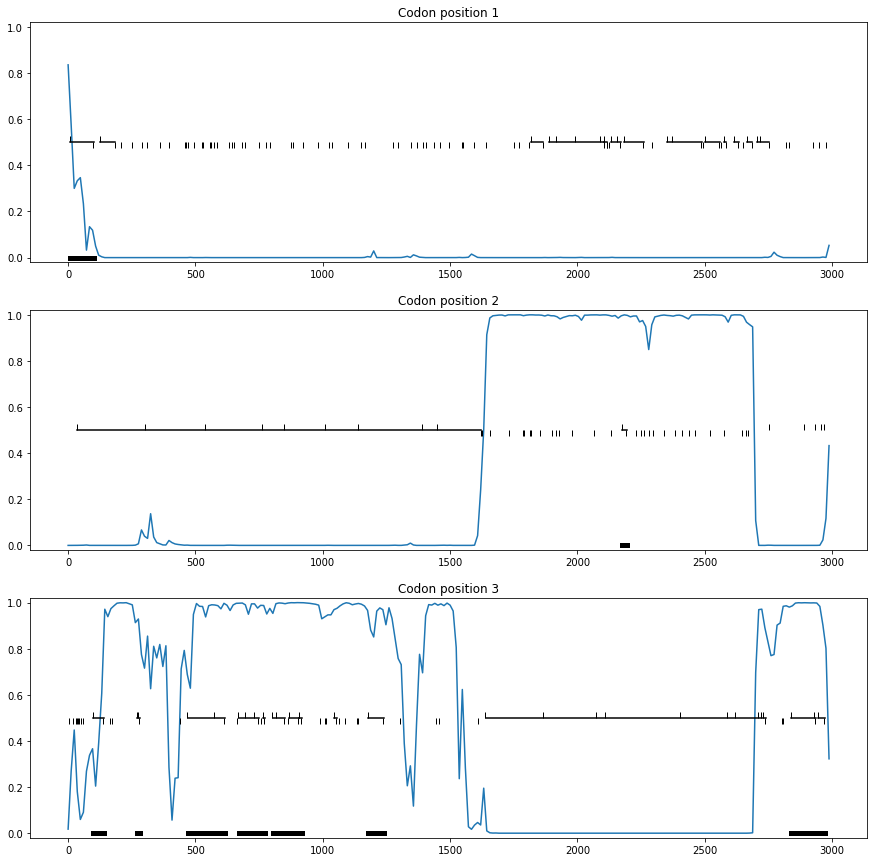

In [13]:
mark1 = GeneMark()
mark1.set_tables(t1,t2)
predicted_genes = mark1.predict(seq, start=0, stop=3000, tol=1e-4, max_iters=1, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### 2. Как в основном задании, но с пересчётом таблиц, начиная с данных выше


Predicted genes:
[[   9  101    1]
 [2176 2193    2]
 [  98  142    3]
 [ 272  283    3]
 [ 470  616    3]
 [ 671  748    3]
 [ 767  775    3]
 [ 803  853    3]
 [ 869  907    3]
 [ 908  919    3]
 [1178 1240    3]
 [2840 2938    3]
 [2945 2971    3]]


  0%|          | 0/10 [00:00<?, ?it/s]

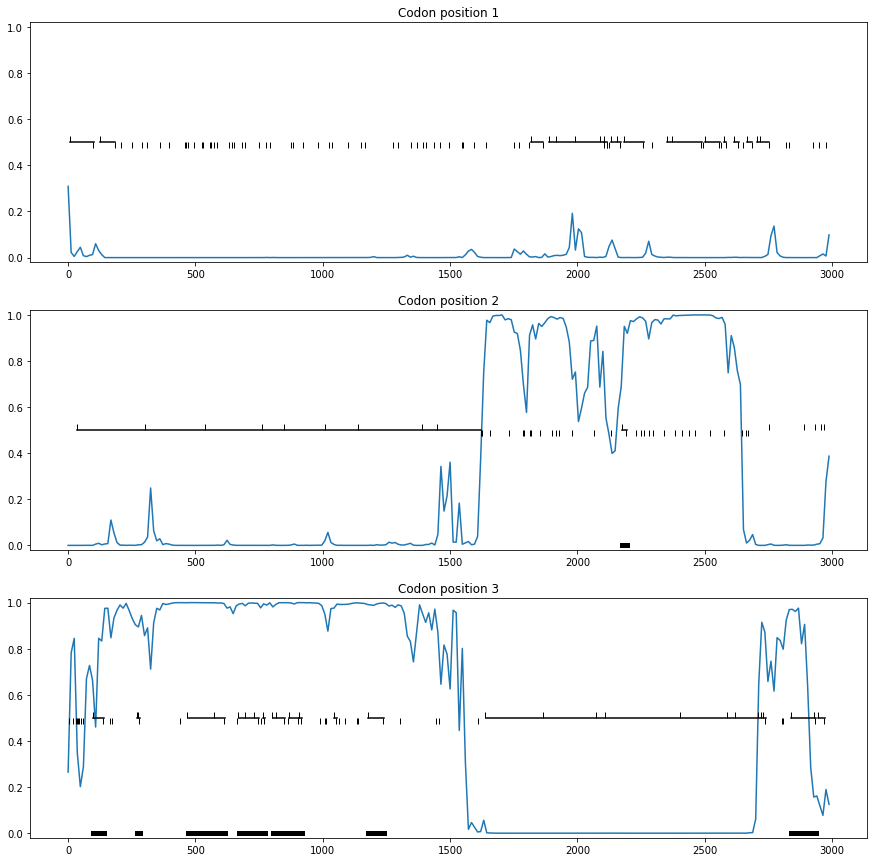


Predicted genes:
[[2176 2193    2]
 [  98  142    3]
 [ 272  283    3]
 [ 470  616    3]
 [ 671  748    3]
 [ 767  775    3]
 [ 803  853    3]
 [ 869  907    3]
 [ 908  919    3]
 [1178 1240    3]
 [2840 2938    3]]


In [14]:
mark2 = GeneMark()
mark2.set_tables(t1,t2)
predicted_genes = mark1.predict(seq, start=0, stop=3000, tol=1e-4, max_iters=10, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### 3. На этом же участке, но не пользуясь изначальными таблицами, а расчитывая их из ORF-ов

  0%|          | 0/10 [00:00<?, ?it/s]

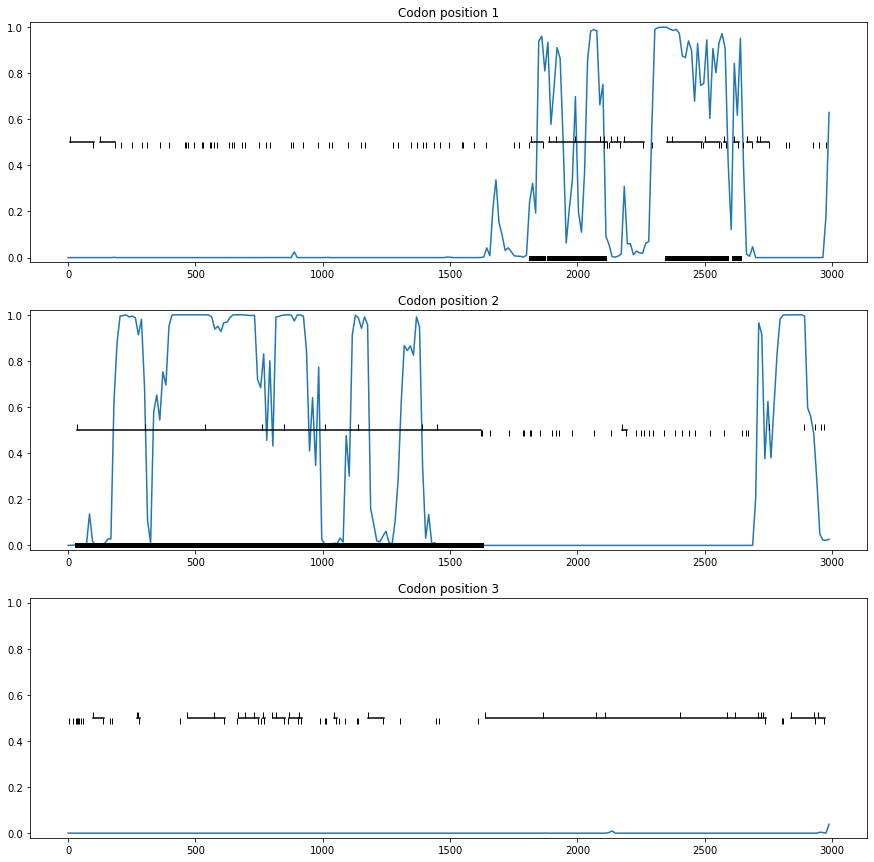


Predicted genes:
[[1818 1865    1]
 [1890 2105    1]
 [2352 2489    1]
 [2502 2558    1]
 [2577 2585    1]
 [2616 2633    1]
 [  34 1623    2]]


In [15]:
mark3 = GeneMark()
predicted_genes = mark3.predict(seq, start=0, stop=3000, tol=1e-4, max_iters=10, no_out=False, both_strands=False)
print(f"\nPredicted genes:\n{predicted_genes}")

### 4. На участке ДНК, который содержит ген как на положительном, так и на отрицательном стренде

#### Выбор такого участка ДНК

In [16]:
tmp = [feature for feature in gb.features if (feature.location.strand==1) \
                                                and (feature.location.end-feature.location.start<3000)\
                                                and (feature.location.end-feature.location.start>1200)]
candidates = []
rev_candidates=[]
for cand in tmp:
  bounds = (cand.location.start - 108, cand.location.start-108+3501)
  flag=False
  tmp=None
  for feat in gb.features:
    if(feat.location.strand==1): continue
    if ((bounds[0] <= feat.location.start < bounds[1]) and (bounds[0] <= feat.location.end < bounds[1]) and (feat.location.end - feat.location.start)>400):
      flag=True
      tmp=feat
      break
  if(flag==True):
    candidates.append(cand)
    rev_candidates.append(tmp)
candidate = candidates[10]
seq = gb.seq[candidate.location.start - 108: candidate.location.start-108+3501]

Также, посмотрим, где в выбранном участке ДНК находится эти гены.

In [17]:
print("На стренде +:", (108, candidate.location.end - (candidate.location.start - 108)))
print("На стренде -:", (rev_candidates[10].location.start-(candidate.location.start - 108)+3, rev_candidates[10].location.end - (candidate.location.start - 108) + 2))

На стренде +: (108, 1491)
На стренде -: (1524, 1979)


#### Запуск

  0%|          | 0/10 [00:00<?, ?it/s]

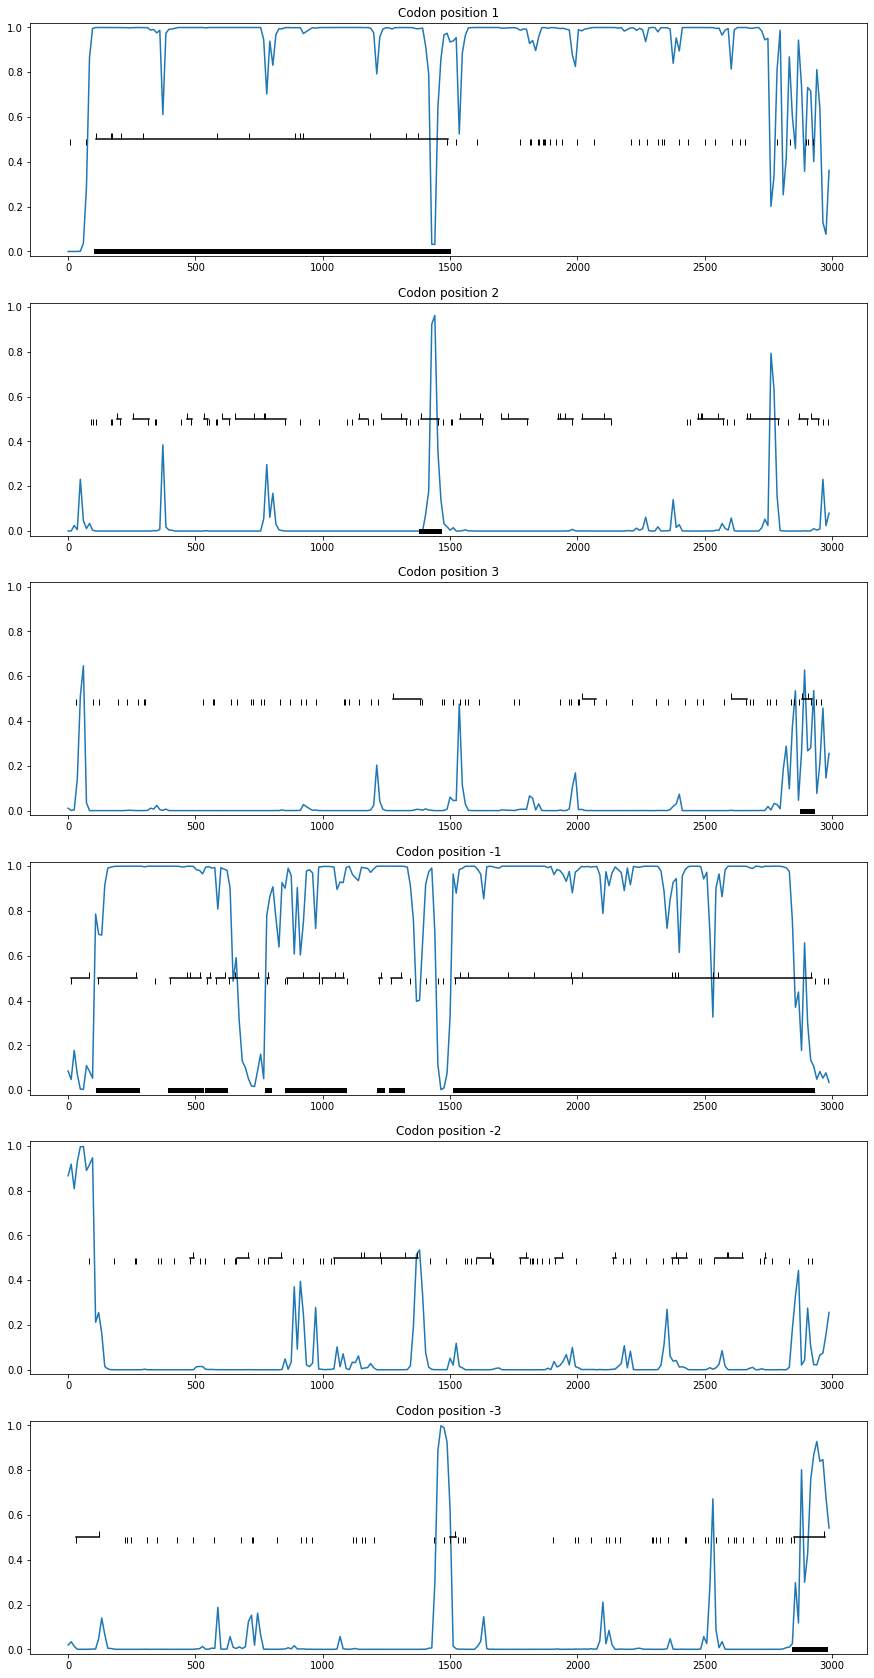


Predicted genes:
[[ 108 1490    1]
 [1387 1455    2]
 [2882 2923    3]
 [1980 2921   -1]
 [1521 1976   -1]
 [1269 1310   -1]
 [1221 1232   -1]
 [ 996 1082   -1]
 [ 858  986   -1]
 [ 780  788   -1]
 [ 582  617   -1]
 [ 546  560   -1]
 [ 402  521   -1]
 [ 117  269   -1]
 [2851 2973   -3]]


In [18]:
mark4 = GeneMark()
predicted_genes = mark4.predict(seq, start=0, stop=3000, tol=1e-4, max_iters=10, no_out=False, both_strands=True)
print(f"\nPredicted genes:\n{predicted_genes}")

### 5. Запуск на файле .fasta (то же самое место в геноме, что и в предыдущем пункте)

  0%|          | 0/10 [00:00<?, ?it/s]

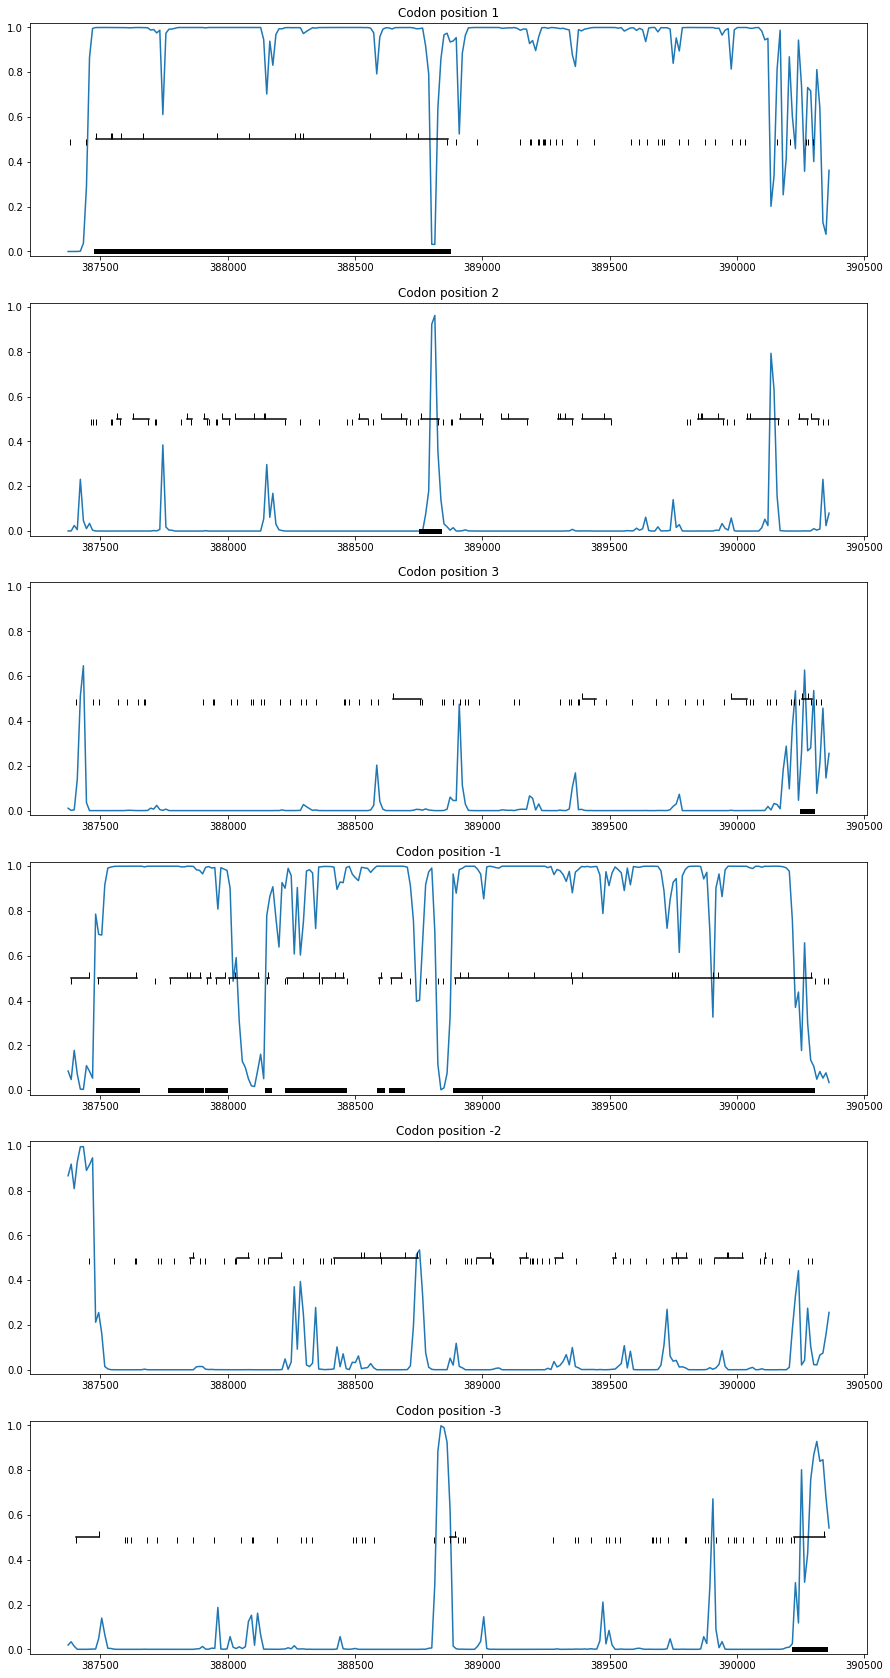


Predicted genes:
[[ 108 1490    1]
 [1387 1455    2]
 [2882 2923    3]
 [1980 2921   -1]
 [1521 1976   -1]
 [1269 1310   -1]
 [1221 1232   -1]
 [ 996 1082   -1]
 [ 858  986   -1]
 [ 780  788   -1]
 [ 582  617   -1]
 [ 546  560   -1]
 [ 402  521   -1]
 [ 117  269   -1]
 [2851 2973   -3]]


In [19]:
mark5 = GeneMark()
predicted_genes = mark5.predict("/content/GCF_000355675.1_ASM35567v1_genomic.fna", start=387482-108, stop=387482-108+3000, tol=1e-4, max_iters=10, no_out=False)
print(f"\nPredicted genes:\n{predicted_genes}")